# Several Sentences Dataset example

In [1]:
import sys
sys.path.append("../../qnlp/quantum")
sys.path.append("../../qnlp/data_preparation")

In [2]:

import pandas as pd
import json
import matplotlib.pyplot as plt

import random
import dictionary
import sentence
import optimizer
import loader
import circuit

## Processing the .json file and preparing the dataset

Several datasets are found in the Dataset folder. 
In the complete dataset, three types of sentences are found:
* NOUN-TVERB-NOUN
* NOUN-IVERB
* NOUN-IVERB-PREP-NOUN

In the dataset used in this notebook example, only transitive sentences are used and the vocabulary is modified from the original Data Preparation module files.



In [3]:
filename = 'Expanded_Transitive_dataset.json'
Dftrain, Dftest = loader.createdf("../../qnlp/quantum/datasets/"+filename)#Dataframe form Json file
#Several datasets are found in the Dataset folder. 
#In the complete dataset, three types of sentences are found:
# 

Myvocab = loader.getvocabdict(Dftrain, Dftest)#A dictionary with word and categories found in dataset

MyDict = dictionary.QuantumDict(qn=1,#Number of qubits for noun category. 
                                qs=1)#Number of qubits for sentence category
MyDict.addwords(myvocab=Myvocab)
MyDict.setvocabparams()#Randomly assign params to words following and ansatz structure.

In [4]:
Dftrain.head()

,sentence,sentence_type,truth_value,sentence_type_code
0,dog eats bone,NOUN-TVERB-NOUN,True,0
1,mouse eats fish,NOUN-TVERB-NOUN,False,0
2,cat eats bone,NOUN-TVERB-NOUN,True,0
3,bird flees cat,NOUN-TVERB-NOUN,True,0
4,dog flees mouse,NOUN-TVERB-NOUN,False,0


In [5]:
Dftest.head()

,sentence,sentence_type,truth_value,sentence_type_code
0,dog chases mouse,NOUN-TVERB-NOUN,True,0
1,bird eats bird,NOUN-TVERB-NOUN,False,0
2,cat eats dog,NOUN-TVERB-NOUN,False,0
3,cat chases mouse,NOUN-TVERB-NOUN,True,0
4,dog eats meat,NOUN-TVERB-NOUN,True,0


-----
For creating the sentences the following ansatz was used.
* qn = 1
* qs = 1

More qubits are shown in the circuit figure for a better understanding of Ansatz shape
<img src="SentenceAnsatz.png">

In [6]:
def createsentencelist(dftrain, mydict):
    sentences_list = []
    for i, DataInstance in dftrain.iterrows():
        a_sentence = sentence.Sentence(DataInstance,
                                       dataset=True,
                                       dictionary=mydict)

        a_sentence.getqbitcontractions()
        a_sentence.setparamsfrommodel(mydict)
        sentences_list.append(a_sentence)

    return sentences_list

In [7]:
    SentencesList = createsentencelist(Dftrain, MyDict)
    SentencesList = [x for x in random.sample(SentencesList, 40)]#For some dataset that may be too big,
                                                                #we can select just a few sentences to try out
                                                                #the model parameters.
    par, ix = MyDict.getindexmodelparams()
    myopt = optimizer.ClassicalOptimizer()
    result = myopt.optimizedataset(SentencesList, par, MyDict,
                                   tol=1e-5,
                                   options={'maxiter':500, 'rhobeg': 1},
                                   method="COBYLA")

iteration 10 
 Cost: 1.0198503274299568
iteration 20 
 Cost: 0.7478418720115596
iteration 30 
 Cost: 0.6599667218391794
iteration 40 
 Cost: 0.5345356163525229
iteration 50 
 Cost: 0.4471222919570592
iteration 60 
 Cost: 0.45213791206280246
iteration 70 
 Cost: 0.4735795098446333
iteration 80 
 Cost: 0.3772853384671605
iteration 90 
 Cost: 0.47968684975784576
iteration 100 
 Cost: 0.3673164370445069
iteration 110 
 Cost: 0.3595967640163468
iteration 120 
 Cost: 0.3549604108269099
iteration 130 
 Cost: 0.33458566729820405
iteration 140 
 Cost: 0.32735254743885156
iteration 150 
 Cost: 0.3425883375861387
iteration 160 
 Cost: 0.2860701390487218
iteration 170 
 Cost: 0.29436419772939704
iteration 180 
 Cost: 0.28941379290614055
iteration 190 
 Cost: 0.36755957998285876
iteration 200 
 Cost: 0.29767047863394663
iteration 210 
 Cost: 0.3126142875491858
iteration 220 
 Cost: 0.26163391296661914
iteration 230 
 Cost: 0.26979805771144416
iteration 240 
 Cost: 0.28076181100661984
iteration 250 

Text(0, 0.5, 'Cost function (Cross entropy)')

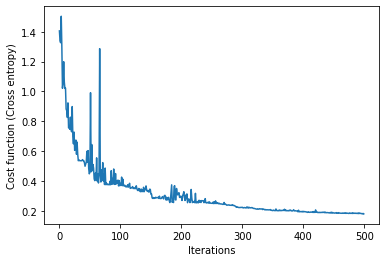

In [8]:
plt.plot(myopt.itercost)
plt.xlabel('Iterations')
plt.ylabel('Cost function (Cross entropy)')

-----------------
## Re-running the sentences of the training dataset

In [9]:
MyDict.updateparams(result.x)
SentencesList = createsentencelist(Dftrain, MyDict)

In [10]:
Dftrain_result = Dftrain.copy()
Result=[]
for i,a_sentence in enumerate(SentencesList):
    mycirc = circuit.CircuitBuilder()
    mycirc.createcircuit(a_sentence, dataset=True)
    mycirc.executecircuit()

    probs = [0, 0]
    # print('sentence: {}'.format(mysentence.sentence))
    for sample in mycirc.result:
        state = sample.state.bitstring
        postselectedqubits = ''.join(state[x] for x in range(len(state)) if x != a_sentence.sentencequbit)
        if postselectedqubits == '0' * (mycirc.qlmprogram.qbit_count - 1):
            if state[a_sentence.sentencequbit] == '0':
                probs[0] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))
            elif state[a_sentence.sentencequbit] == '1':
                probs[1] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (
                #   sample.state, sample.probability, sample.amplitude))
    prob0 = probs[0] / sum(probs)
    prob1 = probs[1] / sum(probs)
    print('Sentence: {}'.format(a_sentence.sentence))
    if a_sentence.label == 0:
        print('label = False')
    elif a_sentence.label == 1:
        print('label = True')
    if prob0 >= 0.5:
        print('I found this sentence to be FALSE')
        if a_sentence.label==0:
            Result.append('Correct')
        elif a_sentence.label==1:
            Result.append('Error')
    else:
        print('I found this sentence to be TRUE')  
        if a_sentence.label==0:
            Result.append('Error')
        elif a_sentence.label==1:
            Result.append('Correct')
    print('------')
Dftrain_result['Result']=Result    


Sentence: dog eats bone
label = True
I found this sentence to be TRUE
------
Sentence: mouse eats fish
label = False
I found this sentence to be FALSE
------
Sentence: cat eats bone
label = True
I found this sentence to be TRUE
------
Sentence: bird flees cat
label = True
I found this sentence to be TRUE
------
Sentence: dog flees mouse
label = False
I found this sentence to be FALSE
------
Sentence: mouse chases dog
label = False
I found this sentence to be FALSE
------
Sentence: mouse flees cat
label = True
I found this sentence to be TRUE
------
Sentence: mouse eats mouse
label = False
I found this sentence to be FALSE
------
Sentence: mouse eats cat
label = False
I found this sentence to be FALSE
------
Sentence: mouse flees fish
label = False
I found this sentence to be FALSE
------
Sentence: cat eats mouse
label = True
I found this sentence to be TRUE
------
Sentence: bird flees dog
label = True
I found this sentence to be TRUE
------
Sentence: dog chases fish
label = False
I fou

---------
## Testing the model in the training dataset

In [11]:
MyDict.updateparams(result.x)
SentencesList = createsentencelist(Dftest, MyDict)

In [12]:
Dftest_result = Dftest.copy()
Result=[]
for a_sentence in SentencesList:
    mycirc = circuit.CircuitBuilder()
    mycirc.createcircuit(a_sentence, dataset=True)
    mycirc.executecircuit()

    probs = [0, 0]
    # print('sentence: {}'.format(mysentence.sentence))
    for sample in mycirc.result:
        state = sample.state.bitstring
        postselectedqubits = ''.join(state[x] for x in range(len(state)) if x != a_sentence.sentencequbit)
        if postselectedqubits == '0' * (mycirc.qlmprogram.qbit_count - 1):
            if state[a_sentence.sentencequbit] == '0':
                probs[0] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))
            elif state[a_sentence.sentencequbit] == '1':
                probs[1] = sample.probability
                # print(
                #    "State %s: probability %s, amplitude %s" % (
                #   sample.state, sample.probability, sample.amplitude))
    prob0 = probs[0] / sum(probs)
    prob1 = probs[1] / sum(probs)
    print('Sentence: {}'.format(a_sentence.sentence))
    if a_sentence.label == 0:
        print('label = False')
    elif a_sentence.label == 1:
        print('label = True')
    if prob0 >= 0.5:
        print('I found this sentence to be FALSE')
        if a_sentence.label==0:
            Result.append('Correct')
        elif a_sentence.label==1:
            Result.append('Error')
    else:
        print('I found this sentence to be TRUE')  
        if a_sentence.label==0:
            Result.append('Error')
        elif a_sentence.label==1:
            Result.append('Correct')
    print('------')
Dftest_result['Result']=Result    


Sentence: dog chases mouse
label = True
I found this sentence to be FALSE
------
Sentence: bird eats bird
label = False
I found this sentence to be FALSE
------
Sentence: cat eats dog
label = False
I found this sentence to be FALSE
------
Sentence: cat chases mouse
label = True
I found this sentence to be FALSE
------
Sentence: dog eats meat
label = True
I found this sentence to be FALSE
------
Sentence: cat eats bird
label = True
I found this sentence to be FALSE
------
Sentence: cat chases fish
label = False
I found this sentence to be FALSE
------
Sentence: dog chases cat
label = True
I found this sentence to be FALSE
------
Sentence: dog flees cat
label = False
I found this sentence to be TRUE
------
Sentence: cat eats meat
label = True
I found this sentence to be TRUE
------
Sentence: bird chases cat
label = False
I found this sentence to be TRUE
------
Sentence: bird flees fish
label = False
I found this sentence to be FALSE
------
Sentence: mouse eats bird
label = False
I found 

------------
We now plot an histogram for the test and train dataset and see how many sentences instances have been correctly labelled and in how many the model has failed. 
We can see that we were successful with the train dataset but now with the test, which may be a sign of overfitting. 
To improve this, we need to further investigate:
* Different Ansaetze
* Different classical optimization methods
* Different datasets

train accuracy = 0.8958333333333334
test accuracy = 0.46153846153846156


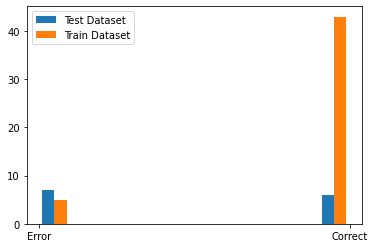

In [13]:
trainaccuracy = (Dftrain_result['Result']=='Correct').sum()/len(Dftrain_result['Result'])
testaccuracy = (Dftest_result['Result']=='Correct').sum()/len(Dftest_result['Result'])

print('train accuracy = {}'.format(trainaccuracy))
print('test accuracy = {}'.format(testaccuracy))

plt.hist([Dftest_result['Result'],Dftrain_result['Result']], label =['Test Dataset', 'Train Dataset'])
plt.legend()

## Missing word guessing

In [57]:
def createDfFromTestSentence(Sentence, vocab, stype):
    PossibleSentences = []
    Stypes=[]
    for word in MyDict.dictionary:
        value = MyDict.dictionary[word]
        if value.wordtype[0] == 'NOUN':
            PossibleSentences.append(Sentence.replace("_", word))
            Stypes.append(stype)
    PossSenDf = pd.DataFrame({"sentence": PossibleSentences, 
                              "sentence_type": Stypes,
                              "sentence_type_code": 0*len(Stypes),
                              "truth_value": 0.5*len(Stypes)})
    return PossSenDf

In [84]:
def getMissingWord(Sentence, vocab, stype, MyDict):
    PossSenDF = createDfFromTestSentence(Sentence, vocab, stype)
    PossSenList = createsentencelist(PossSenDF, MyDict)
    
    PossibleSentenceDF_result = PossibleSentenceDF.copy()
    PossSenResult={}
    
    for a_sentence in PossSenList:
        mycirc = circuit.CircuitBuilder()
        mycirc.createcircuit(a_sentence, dataset=True)
        mycirc.executecircuit()

        probs = [0, 0]
        # print('sentence: {}'.format(mysentence.sentence))
        for sample in mycirc.result:
            state = sample.state.bitstring
            postselectedqubits = ''.join(state[x] for x in range(len(state)) if x != a_sentence.sentencequbit)
            if postselectedqubits == '0' * (mycirc.qlmprogram.qbit_count - 1):
                if state[a_sentence.sentencequbit] == '0':
                    probs[0] = sample.probability
                    # print(
                    #    "State %s: probability %s, amplitude %s" % (sample.state, sample.probability, sample.amplitude))
                elif state[a_sentence.sentencequbit] == '1':
                    probs[1] = sample.probability
                    # print(
                    #    "State %s: probability %s, amplitude %s" % (
                    #   sample.state, sample.probability, sample.amplitude))
        prob0 = probs[0] / sum(probs)
        prob1 = probs[1] / sum(probs)
        print('Sentence: {}'.format(a_sentence.sentence))
        PossSenResult[a_sentence.sentence] = prob1
        print(prob1)
    print("--------")
    print("I guess that {} sounds good to me".format(max(PossSenResult, key=PossSenResult.get)))
    

In [94]:
getMissingWord("_ flees dog", Myvocab, "NOUN-TVERB-NOUN", MyDict)
print("\n")
getMissingWord("_ eats fish", Myvocab, "NOUN-TVERB-NOUN", MyDict)
print("\n")
getMissingWord("_ eats mouse", Myvocab, "NOUN-TVERB-NOUN", MyDict)
print("\n")
getMissingWord("dog eats _", Myvocab, "NOUN-TVERB-NOUN", MyDict)


Sentence: dog flees dog
0.7853441672828345
Sentence: bone flees dog
0.6951706404611332
Sentence: mouse flees dog
0.7697833897125629
Sentence: fish flees dog
0.788474009780866
Sentence: cat flees dog
0.7714563053474869
Sentence: bird flees dog
0.9188255268740065
Sentence: seed flees dog
0.6919986165985383
Sentence: meat flees dog
0.7325716966957909
--------
I guess that bird flees dog sounds good to me


Sentence: dog eats fish
0.06693826724306812
Sentence: bone eats fish
0.059213368469697616
Sentence: mouse eats fish
0.18797212290263318
Sentence: fish eats fish
0.17186319620684884
Sentence: cat eats fish
0.8518807068900163
Sentence: bird eats fish
0.6754795539934825
Sentence: seed eats fish
0.05887994498468877
Sentence: meat eats fish
0.09318739603708165
--------
I guess that cat eats fish sounds good to me


Sentence: dog eats mouse
0.09018011808154651
Sentence: bone eats mouse
0.08000300969434614
Sentence: mouse eats mouse
0.22283576393576
Sentence: fish eats mouse
0.2862401131799101